In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import missingno as msn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor

    VendorName      ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0      adviser          32/60   125   256   6000   256     16    128  198  199
1       amdahl         470v/7    29  8000  32000    32      8     32  269  253
2       amdahl        470v/7a    29  8000  32000    32      8     32  220  253
3       amdahl        470v/7b    29  8000  32000    32      8     32  172  253
4       amdahl        470v/7c    29  8000  16000    32      8     16  132  132
..         ...            ...   ...   ...    ...   ...    ...    ...  ...  ...
204     sperry         Aug-80   124  1000   8000     0      1      8   42   37
205     sperry  90/80-model-3    98  1000   8000    32      2      8   46   50
206     sratus             32   125  2000   8000     0      2     14   52   41
207       wang         vs-100   480   512   8000    32      0      0   67   47
208       wang          vs-90   480  1000   4000     0      0      0   45   25

[209 rows x 10 columns]
<class 'pandas.core.frame.D

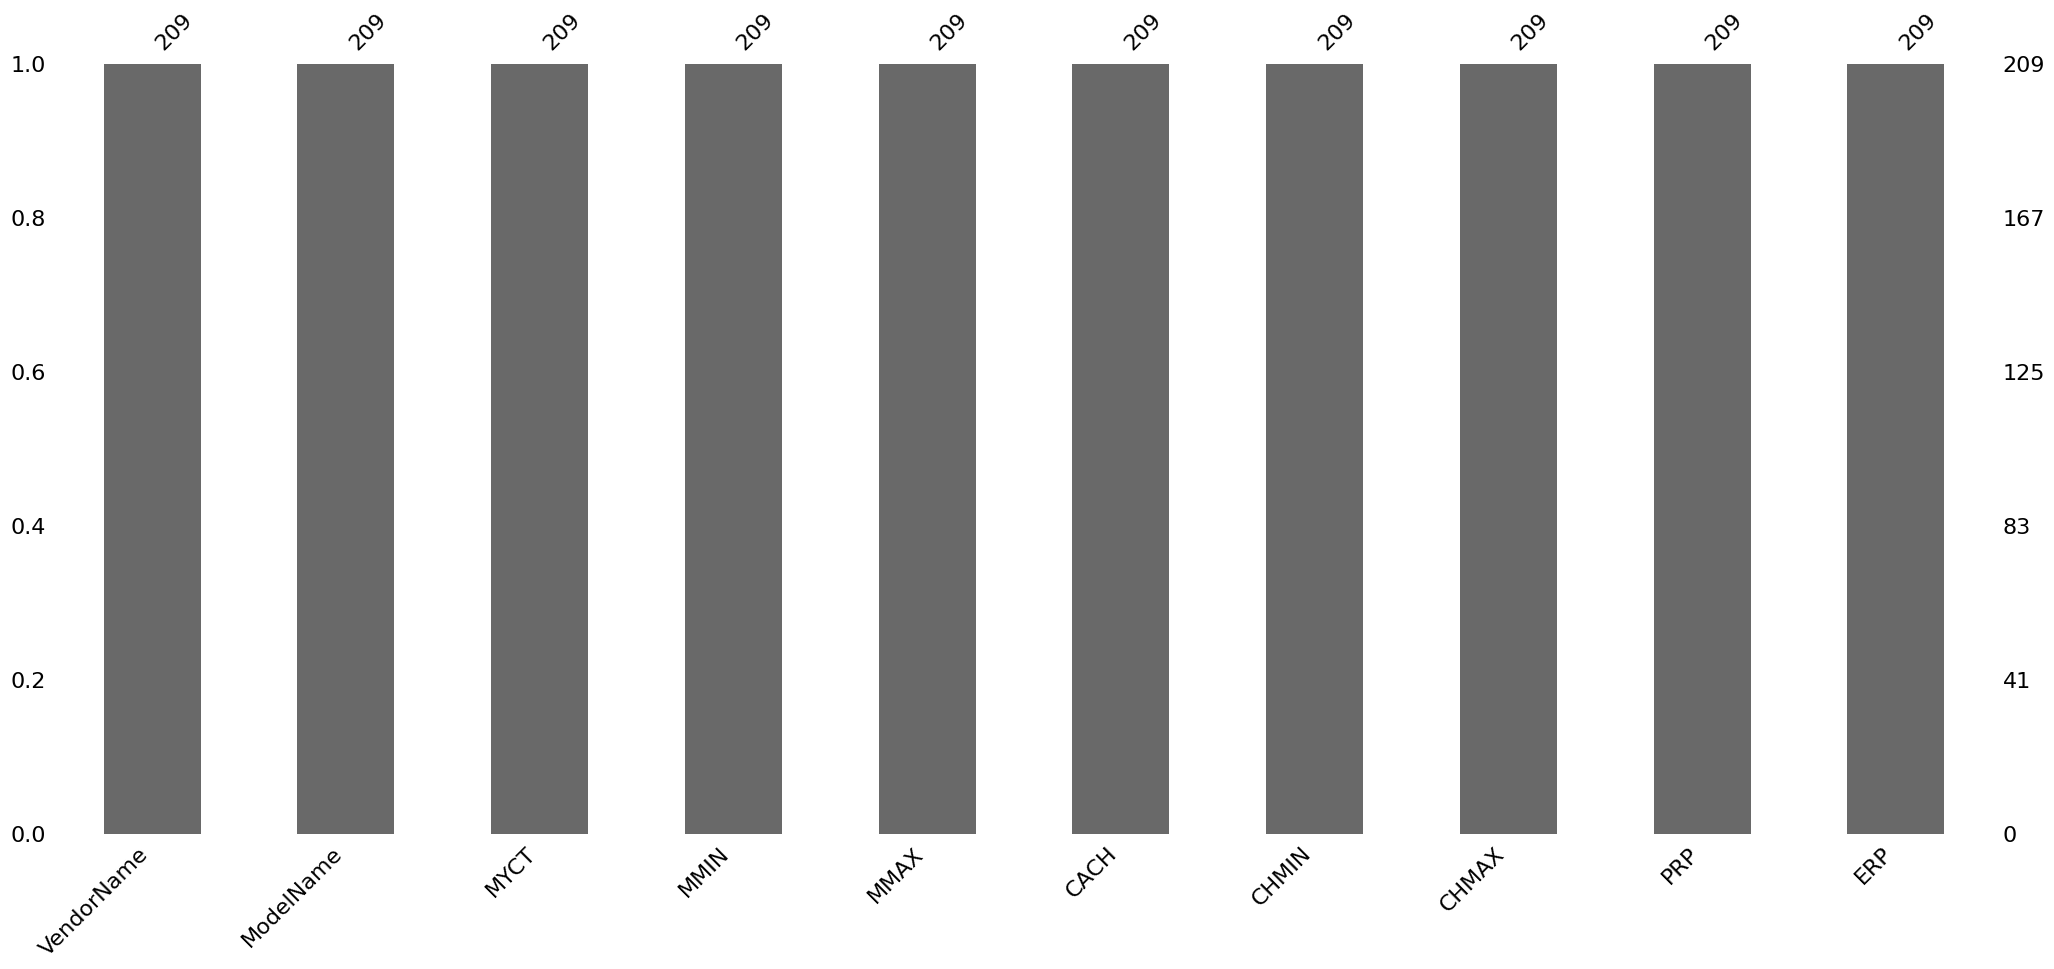

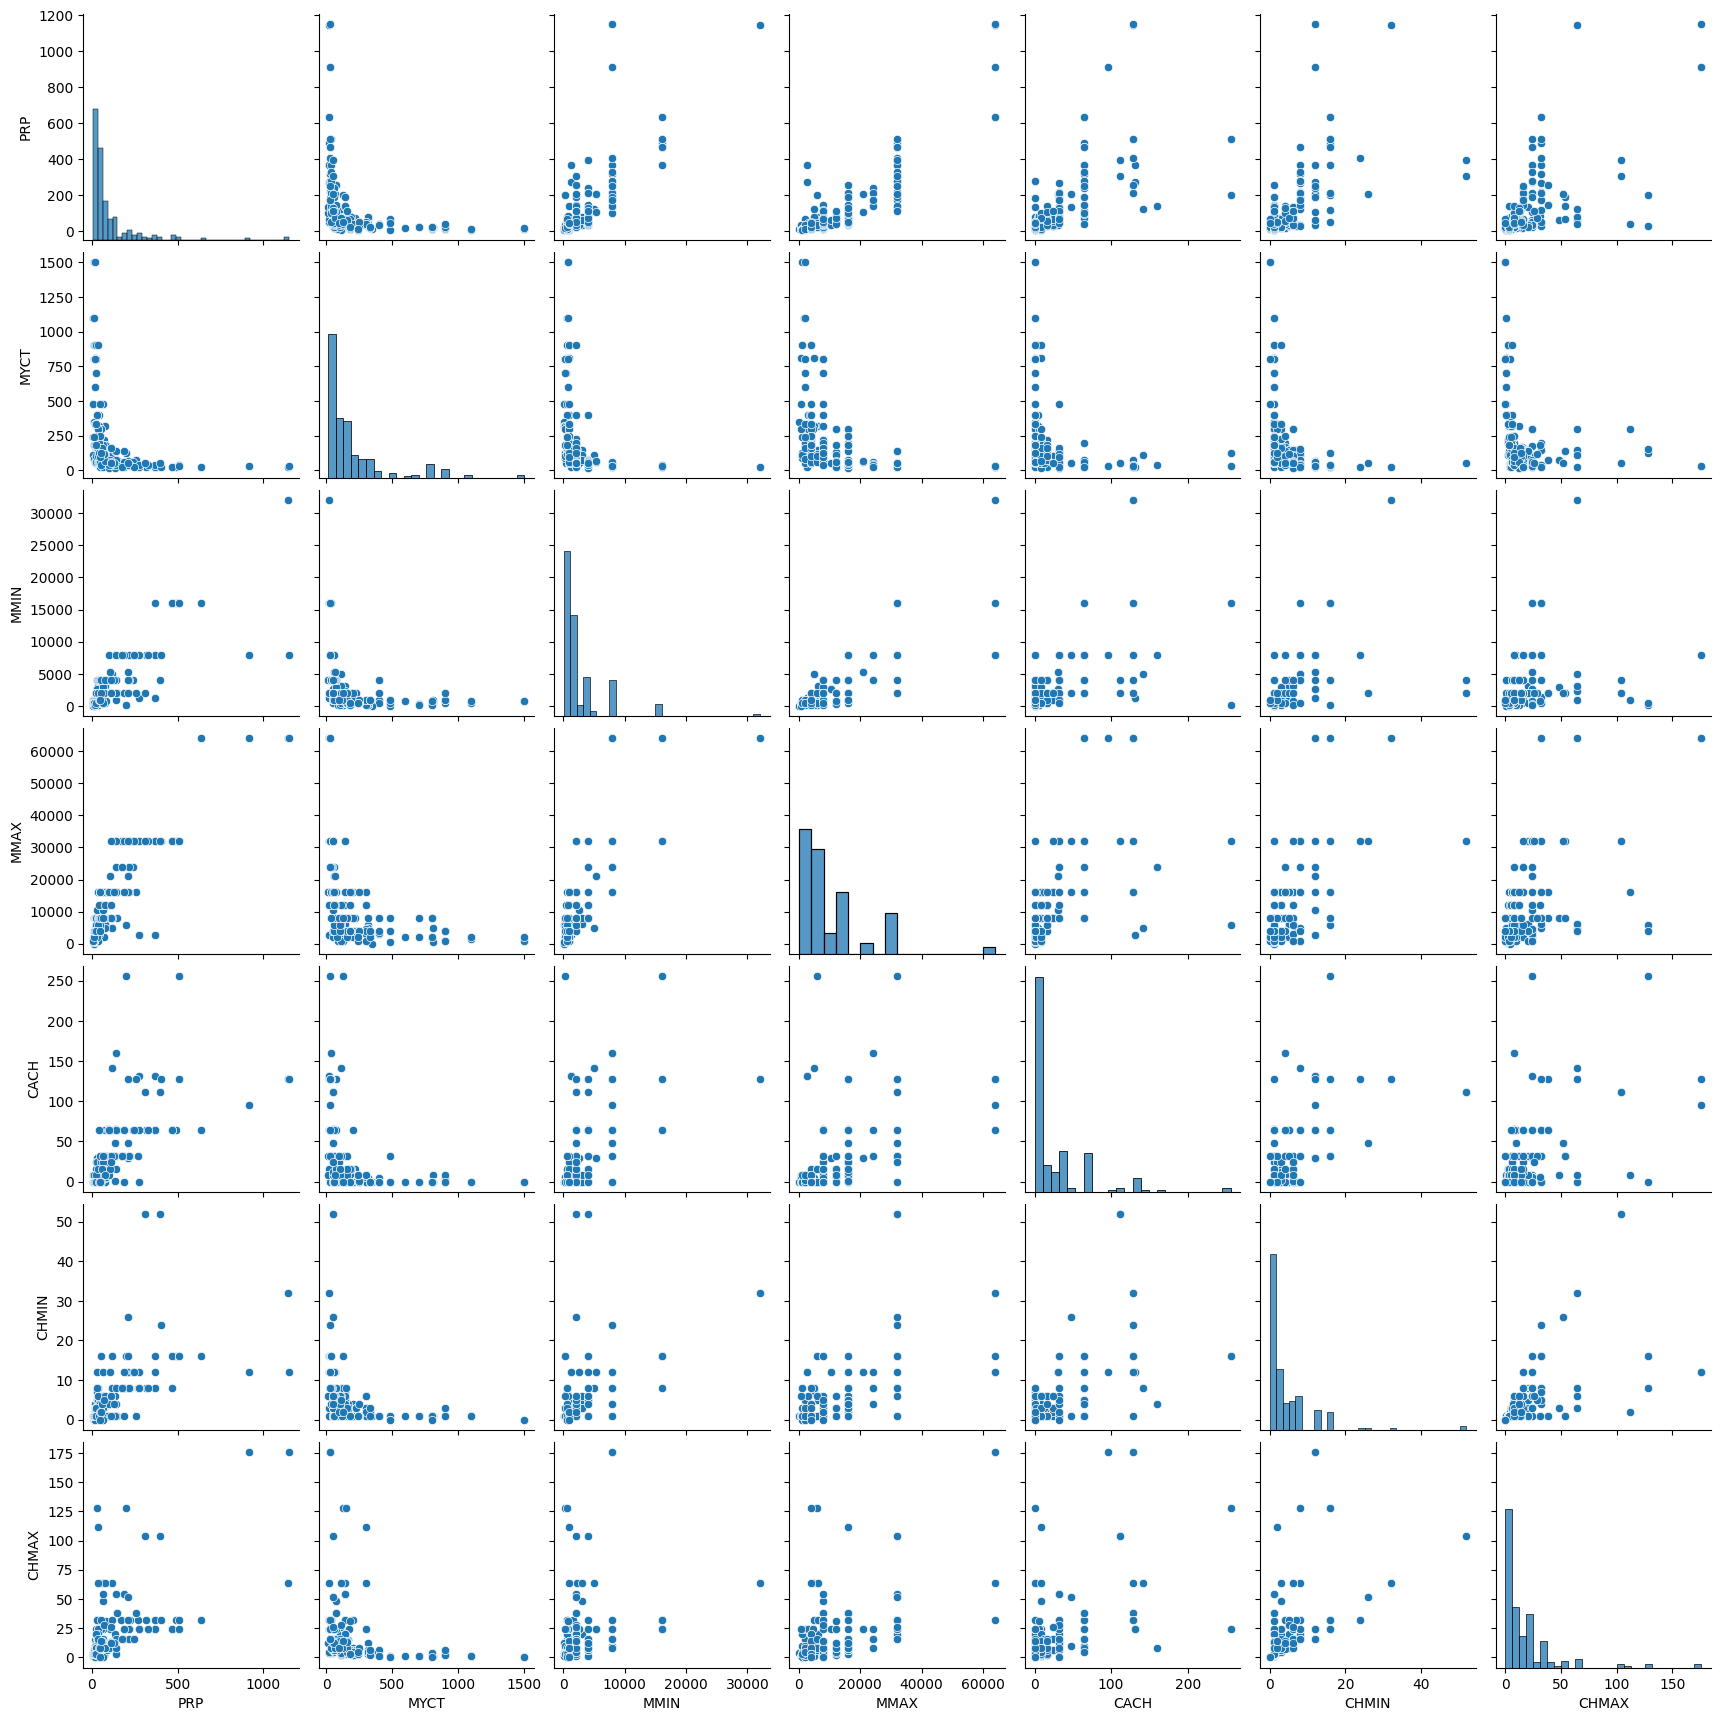

교차 검증
MSE 평균 : 5941.453778179215
R^2 평균 : 0.6508224821731221
테스트 데이터
MSE : 5633.068155793253
MAE : 48.068801347004765
R^2 : 0.8893455830696775



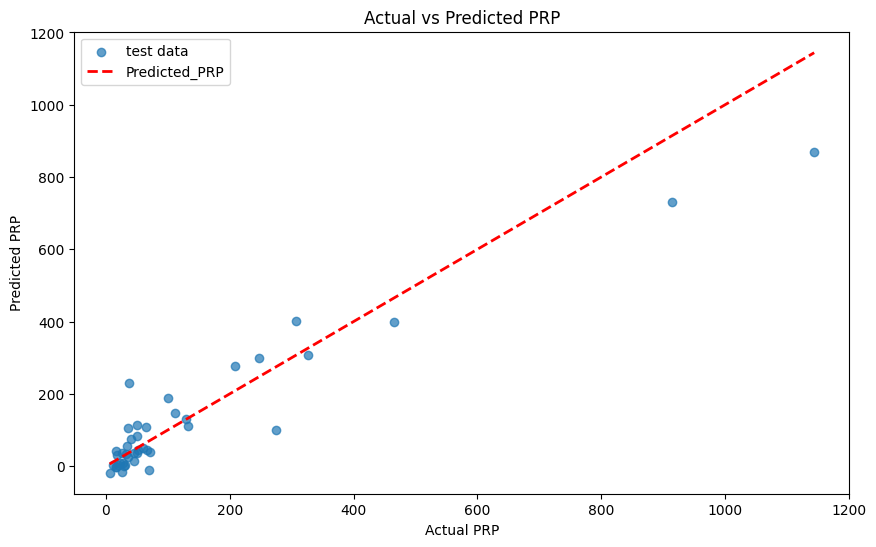

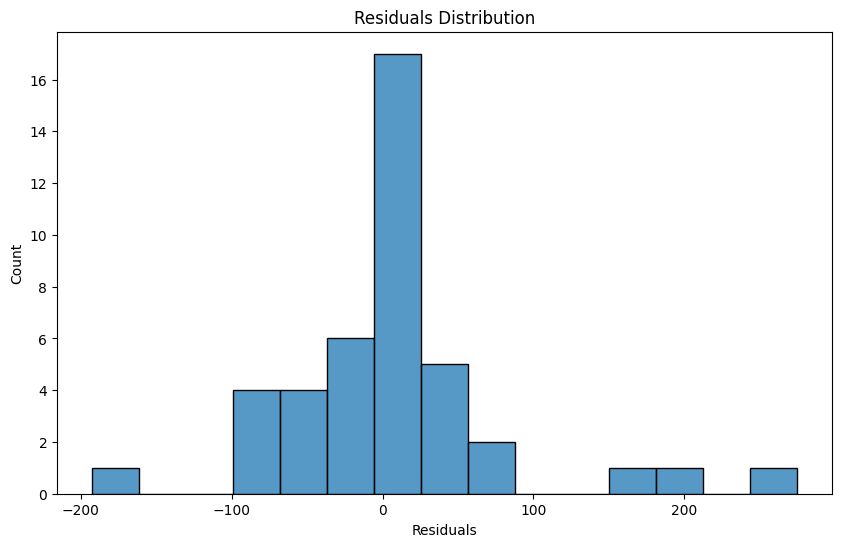

In [2]:
# 데이터 불러오기
data = pd.read_csv('machine.data_update.csv')

# 데이터 탐색 
print(data)
print(data.info())
print(data.describe())

# 결측치 확인
data.isnull().sum()
msn.bar(data)

# 범주형 변수 수치화
dum = pd.get_dummies(data['VendorName'], prefix='vendor_name', dtype=float)
data = pd.concat([data.drop('VendorName', axis=1), dum], axis=1)

dum= pd.get_dummies(data['ModelName'], prefix='model_name', dtype=float)
data = pd.concat([data.drop('ModelName', axis=1), dum], axis=1)

features = ['PRP','MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
# features에 대한 쌍 그래프 그리기
sns.pairplot(data[features])
plt.show()

# features 선택 (ERP는 개선에 이용)
features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']


# X와 y 설정
X = data[features]
y = data['PRP']

# 훈련 데이터와 테스트 데이터 분리(훈련 데이터 80%, 테스트 데이터 20%로 설정)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 선택 및 학습
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 예측
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print("교차 검증")
# 교차 검증 MSE 계산
cv_mse_scores = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"MSE 평균 : {cv_mse_scores.mean()}")

# 교차 검증 R^2 계산
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"R^2 평균 : {cv_scores.mean()}")

# 테스트 데이터 성능 평가
print("테스트 데이터")
print(f"MSE : {mean_squared_error(y_test, y_test_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_test_pred)}")
print(f"R^2 : {r2_score(y_test, y_test_pred)}")
print()
# 실제값과 예측값을 시각화한다.
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, label="test data") # 실제 PRP값과 예측된 PRP값을 산포도로 표시한다.
plt.xlabel("Actual PRP")
plt.ylabel("Predicted PRP")
plt.title("Actual vs Predicted PRP")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label = 'Predicted_PRP')
plt.legend()
# 대각선으로 실제값과 예측값이 일치하는 선을 추가해 모델의 예측 정확도를 시각적으로 평가한다.
plt.show()

# 잔차 시각화
plt.figure(figsize=(10, 6))
residuals = y_test - y_test_pred # 실제값과 예측값의 차이를 계산하여 잔차를 구한다.
sns.histplot(residuals) # 잔차의 분포를 히스토그램으로 시각화한다.
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.show()

In [3]:
print("교차 검증")
# 교차 검증 MSE 계산
cv_mse_scores = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"MSE : {cv_mse_scores.mean()}")

# 교차 검증 MAE 계산
cv_mae_scores = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE : {cv_mae_scores.mean()}")

# 교차 검증 R^2 계산
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"R^2 : {cv_scores.mean()}")

# 훈련 데이터 성능 평가
print()
print("훈련 데이터 성능")
print(f"MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"MAE : {mean_absolute_error(y_train, y_train_pred)}")
print(f"R^2 : {r2_score(y_train, y_train_pred)}")
print()

# 테스트 데이터 성능 평가
print("테스트 데이터")
print(f"MSE : {mean_squared_error(y_test, y_test_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_test_pred)}")
print(f"R^2 : {r2_score(y_test, y_test_pred)}")
print()

교차 검증
MSE : 5941.453778179215
MAE : 40.989729272463954
R^2 : 0.6508224821731221

훈련 데이터 성능
MSE: 3117.658905430178
MAE : 35.12200634651686
R^2 : 0.8378284557995717

테스트 데이터
MSE : 5633.068155793253
MAE : 48.068801347004765
R^2 : 0.8893455830696775



    VendorName      ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0      adviser          32/60   125   256   6000   256     16    128  198  199
1       amdahl         470v/7    29  8000  32000    32      8     32  269  253
2       amdahl        470v/7a    29  8000  32000    32      8     32  220  253
3       amdahl        470v/7b    29  8000  32000    32      8     32  172  253
4       amdahl        470v/7c    29  8000  16000    32      8     16  132  132
..         ...            ...   ...   ...    ...   ...    ...    ...  ...  ...
204     sperry         Aug-80   124  1000   8000     0      1      8   42   37
205     sperry  90/80-model-3    98  1000   8000    32      2      8   46   50
206     sratus             32   125  2000   8000     0      2     14   52   41
207       wang         vs-100   480   512   8000    32      0      0   67   47
208       wang          vs-90   480  1000   4000     0      0      0   45   25

[209 rows x 10 columns]
<class 'pandas.core.frame.D

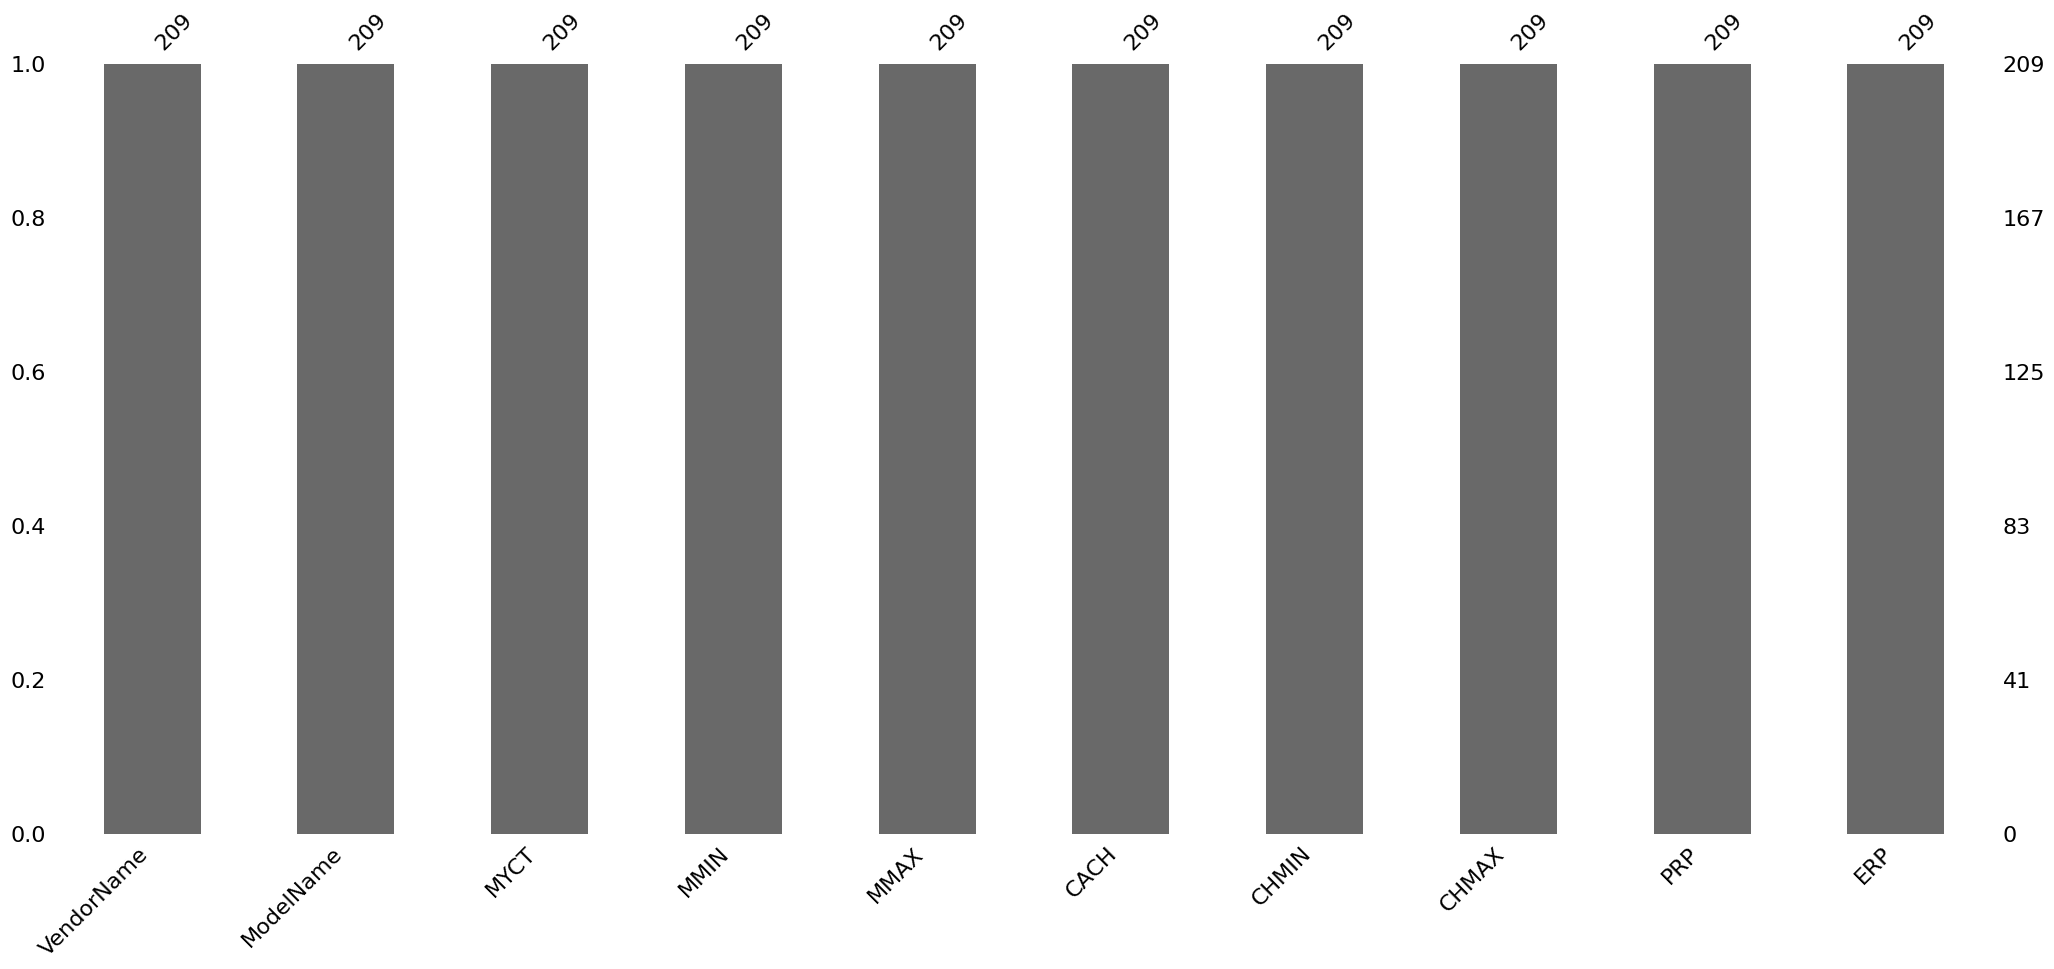

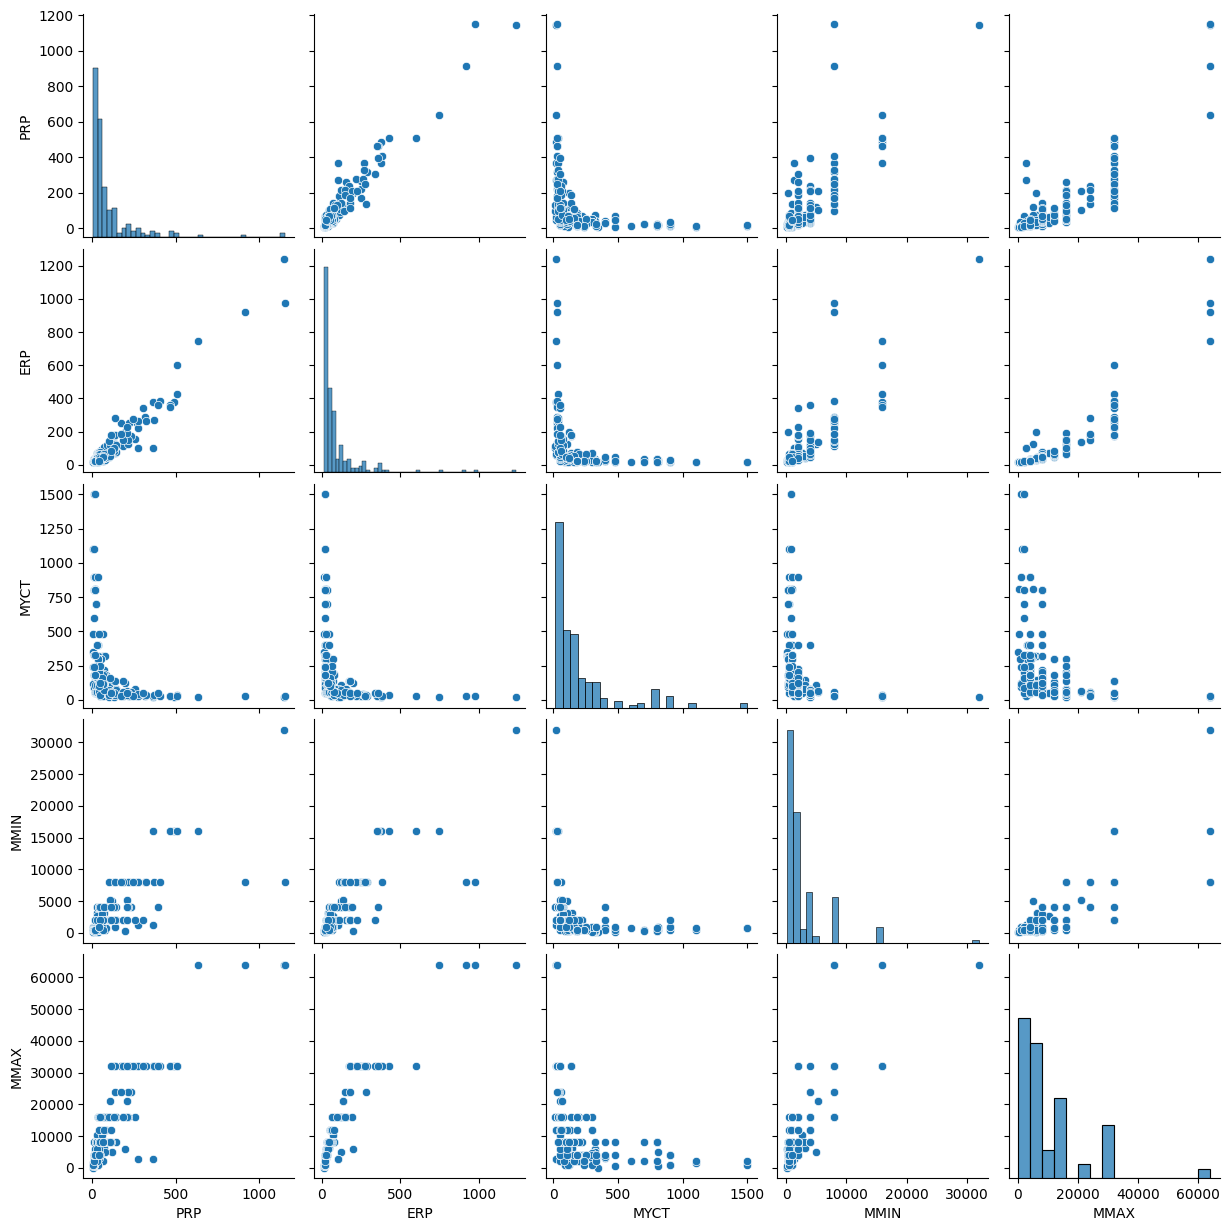

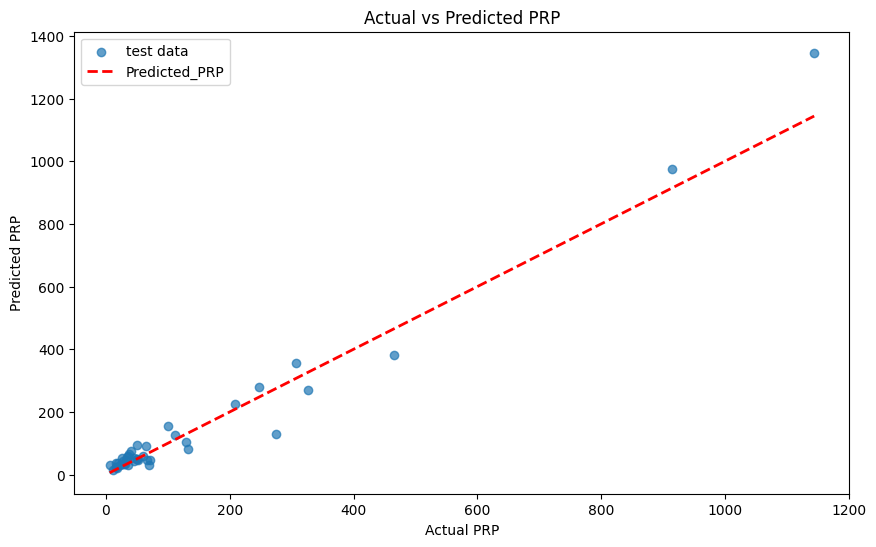

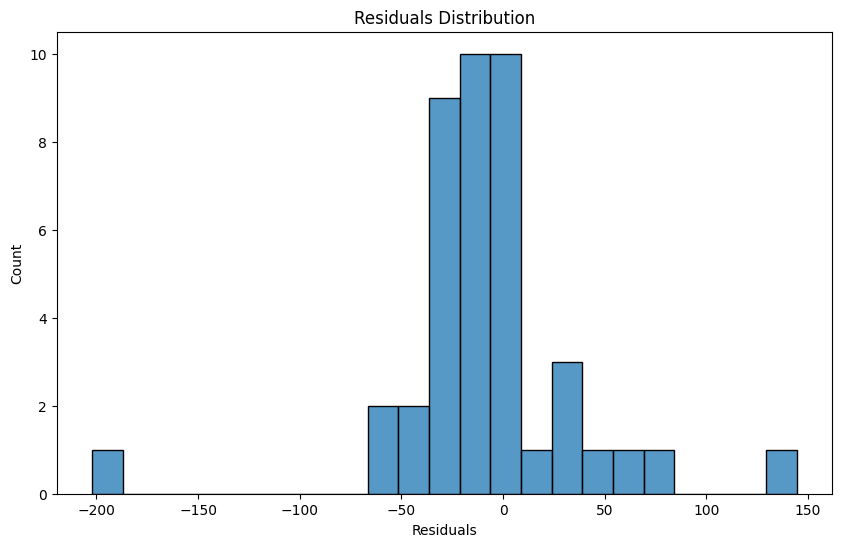

테스트 데이터
MSE : 2294.003460281148
MAE : 29.50722907438932
R^2 : 0.954937236988249



In [4]:
# 데이터 불러오기
data = pd.read_csv('machine.data_update.csv')

# 데이터 탐색 
print(data)
print(data.info())
print(data.describe())

# 결측치 확인
data.isnull().sum()
msn.bar(data)

# 범주형 변수 수치화
dum = pd.get_dummies(data['VendorName'], prefix='vendor_name', dtype=float)
data = pd.concat([data.drop('VendorName', axis=1), dum], axis=1)

dum= pd.get_dummies(data['ModelName'], prefix='model_name', dtype=float)
data = pd.concat([data.drop('ModelName', axis=1), dum], axis=1)

# 상관계수 계산
result = data.corr()['PRP']

# 상관계수 값을 양의 상관계수로 처리
result = np.abs(result)

# 상관계수를 내림차순으로 정렬하기
print(result.sort_values(ascending = False))
# features 선택 (상위 4개)
features = ['PRP', 'ERP', 'MYCT', 'MMIN', 'MMAX']
# features에 대한 쌍 그래프 그리기
sns.pairplot(data[features])
plt.show()

# features 선택 (상위 4개 특성만 선택)
features = ['ERP','MYCT', 'MMIN', 'MMAX']


# X와 y 설정
X = data[features]
y = data['PRP']

# 훈련 데이터와 테스트 데이터 분리(훈련 데이터 80%, 테스트 데이터 20%로 설정)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 선택 및 학습
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 예측
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# 실제값과 예측값을 시각화한다.
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, label="test data") # 실제 PRP값과 예측된 PRP값을 산포도로 표시한다.
plt.xlabel("Actual PRP")
plt.ylabel("Predicted PRP")
plt.title("Actual vs Predicted PRP")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label = 'Predicted_PRP')
plt.legend()
# 대각선으로 실제값과 예측값이 일치하는 선을 추가해 모델의 예측 정확도를 시각적으로 평가한다.
plt.show()

# 잔차 시각화
plt.figure(figsize=(10, 6))
residuals = y_test - y_test_pred # 실제값과 예측값의 차이를 계산하여 잔차를 구한다.
sns.histplot(residuals) # 잔차의 분포를 히스토그램으로 시각화한다.
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.show()
# 테스트 데이터 성능 평가
print("테스트 데이터")
print(f"MSE : {mean_squared_error(y_test, y_test_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_test_pred)}")
print(f"R^2 : {r2_score(y_test, y_test_pred)}")
print()

In [5]:
print("교차 검증")
# 교차 검증 MSE 계산
cv_mse_scores = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"MSE : {cv_mse_scores.mean()}")

# 교차 검증 MAE 계산
cv_mae_scores = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE : {cv_mae_scores.mean()}")

# 교차 검증 R^2 계산
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"R^2 : {cv_scores.mean()}")

# 훈련 데이터 성능 평가
print()
print("훈련 데이터 성능")
print(f"MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"MAE : {mean_absolute_error(y_train, y_train_pred)}")
print(f"R^2 : {r2_score(y_train, y_train_pred)}")
print()

# 테스트 데이터 성능 평가
print("테스트 데이터")
print(f"MSE : {mean_squared_error(y_test, y_test_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_test_pred)}")
print(f"R^2 : {r2_score(y_test, y_test_pred)}")
print()

교차 검증
MSE : 2032.7762301269565
MAE : 25.660890171208536
R^2 : 0.8759006296346618

훈련 데이터 성능
MSE: 1599.0193201672178
MAE : 23.673727071682297
R^2 : 0.9168236679432202

테스트 데이터
MSE : 2294.003460281148
MAE : 29.50722907438932
R^2 : 0.954937236988249



In [6]:
# 성능 지표 저장
performance = {
    'model': ['Linear Regression', 'Linear Regression', 'Linear Regression'],
    'data': ['Cross Validation','Train', 'Test'],
    'mse': [2032.7762301269565, 1599.0193201672178, 2294.003460281148],
    'mae': [25.660890171208536, 23.673727071682297, 29.50722907438932],
    'R^2': [0.8759006296346618, 0.9168236679432202, 0.954937236988249]
}

# 데이터프레임 생성
Linear_Regression_Result = pd.DataFrame(performance)

# 데이터프레임을 CSV 파일로 저장
Linear_Regression_Result.to_csv('Linear_Regression_Result.csv', index=False)

Linear_Regression_Result

,model,data,mse,mae,R^2
0,Linear Regression,Cross Validation,2032.77623,25.660890,0.875901
1,Linear Regression,Train,1599.01932,23.673727,0.916824
2,Linear Regression,Test,2294.00346,29.507229,0.954937
